## Robust plan

In [1]:
using JuMP, Gurobi, Plots, LinearAlgebra
GRB_ENV = Gurobi.Env();

Academic license - for non-commercial use only


### Create model for dynamics

In [2]:
dt = 0.1
A = zeros(4,4)+I
A[1,2] = A[3,4] = dt
B = zeros(4,2)
B[2,1] = B[4,2] = dt
C = zeros(2,4)
C[1,2] = C[2,4] = 1
D = zeros(2,2)
Bw = copy(B);

### Create model

In [37]:
T = 0.9
N = Int(T/dt);
x0 = [0;0;0;0]
xN = [0.03;0;0.035;0]
ϵ = 0.0001 # how close to the goal we want to get

0.0001

## Obstacles

In [4]:
P = [-1 0; 0 1]
q = [-0.03; 0.03] # this should be feasible
m = length(q)
obj = [[1,2]] # Each entry corresponds to the lines defining an object
Nobj = length(obj)
M = 1000; #Big M

## Helper vars

In [5]:
Q = zeros(2,4)
Q[1,2] = Q[2,4] = 1
N_K = Int((N-1)*N/2) # number of K's
Ak = zeros(N,4,4)
Ak[1,:,:] = zeros(Int, size(A))+I
for i=2:N
    Ak[i,:,:] = A*Ak[i-1,:,:]
end
Ai = i -> Ak[i,:,:]
get_cone = (i,j) -> Int((i-2)*(i-3)/2)+j;

In [6]:
get_cone(3,1),get_cone(4,1),get_cone(4,2),get_cone(5,1)

(1, 2, 3, 4)

## Robustness parameters

In [191]:
ρ = 0.001;

## Model

In [192]:
model = Model(optimizer_with_attributes(
        () -> Gurobi.Optimizer(GRB_ENV), #"OutputFlag" => 0
    ));
@variable(model, K[1:N_K,1:2,1:2])   # Control law linear
@variable(model, α[1:2, 1:N])      # Control law constant
@variable(model, au[1:2, 1:N] >=0) # Absolute value of u(control)
@variable(model, z[1:N, 1:m] >=0, Bin) # Binary vars for obstacles
# Variables for auxiliary second order cones:
@variable(model, t[1:N_K,1:m] >= 0) # (we need one for each halfplane)
@variable(model, s[1:N_K,1:2] >= 0); # (one for each control vector)
@variable(model, r[1:N_K,1:4] >= 0); # (one for each state variable)

In [193]:
@constraint(model, cobj[k=2:N, i=1:Nobj],
   sum(z[k,j] for j in obj[i]) == length(obj[i])-1); # Obstacles

In [194]:
#[get_cone(k,i) for i=1:k-2]

In [195]:
#k = 4
#i = 1; #to k-2

In [196]:
#[(j,i) for j=(i+1):(k-1)]

In [197]:
P*Q

2×4 Array{Float64,2}:
 0.0  -1.0  0.0  0.0
 0.0   0.0  0.0  1.0

## Obstacle free path

In [198]:
# Time step k=2
@constraint(model, (P*Q*Ai(2)*x0+P*Q*B*α[:,2]
        +ρ*mapslices(norm, P*Q*Bw, dims=2)[:]) .<= q+M*z[2,:]);
# All time steps after:
@constraint(model, [k=3:N], (P*Q*Ai(k)*x0+sum(P*Q*Ai(k-i)*B*α[:,i] for i=1:k-1)
        +sum(ρ*t[get_cone(k,i),:] for i=1:k-2)
        +ρ*mapslices(norm, P*Q*Bw, dims=2)[:]) .<= q+M*z[k,:]);

### Maximum control

In [199]:
@constraint(model, α[:,2] .<= au[:,2])
@constraint(model, -au[:,2] .<= α[:,2])
@constraint(model, [k=3:N-1], α[:,k]+ρ*sum(s[get_cone(k,i),:] for i=1:k-2) .<= au[:,k])
@constraint(model, [k=3:N-1],  -α[:,k]+ρ*sum(s[get_cone(k,i),:] for i=1:k-2) .<= au[:,k]);

### Goals

In [200]:
@constraint(model, (Ai(N)*x0+sum(Ai(N-i)*B*α[:,i] for i=1:N-1)
        +sum(ρ*r[get_cone(N,i),:] for i=1:N-2)
        +ρ*mapslices(norm, Bw, dims=2)[:]) .<= xN+ϵ);
@constraint(model, (-Ai(N)*x0+sum(Ai(N-i)*B*-α[:,i] for i=1:N-1)
        +sum(ρ*r[get_cone(N,i),:] for i=1:N-2)
        +ρ*mapslices(norm, Bw, dims=2)[:]) .<= -xN+ϵ);

## Second order constraints

### 1) Obstacles

In [201]:
@constraint(model, obs[k=3:N,i=1:(k-2),l=1:m], vcat(t[get_cone(k,i),l], (P*Q*Ai(k-i)*Bw)[l,:]+sum(
            (P*Q*Ai(k-j)*B*K[get_cone(j,i),:,:])[l,:] for j=(i+1):(k-1))) in SecondOrderCone());

### 2) Control

In [202]:
@constraint(model, [k=3:N-1,i=1:(k-2),l=1:2], vcat(s[get_cone(k,i),l], sum(
            K[get_cone(j,i),l,:] for j=(i+1):(k-1))) in SecondOrderCone());

### 3) Goals

In [203]:
@constraint(model, [k=3:N,i=1:(k-2),l=1:4], vcat(r[get_cone(k,i),l], (Ai(k-i)*Bw)[l,:]+sum(
            (Ai(k-j)*B*K[get_cone(j,i),:,:])[l,:] for j=(i+1):(k-1))) in SecondOrderCone());

### Objective

In [204]:
@objective(model, Min, sum(au));

## Optimize

In [205]:
optimize!(model)

Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 654 rows, 1080 columns and 2216 nonzeros
Model fingerprint: 0xd9db33f6
Model has 210 quadratic constraints
Variable types: 1062 continuous, 18 integer (18 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+03]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+00]
Presolve removed 444 rows and 600 columns
Presolve time: 0.03s
Presolved: 798 rows, 1068 columns, 2093 nonzeros
Presolved model has 196 quadratic constraint(s)
Variable types: 1060 continuous, 8 integer (8 binary)
Presolve removed 430 rows and 430 columns
Presolve time: 0.04s
Presolved: 368 rows, 638 columns, 1249 nonzeros
Presolved model has 196 second-order cone constraints
Root barrier log...

Ordering time: 0.00s

Barrier statistics:
 Free vars  : 26
 AA' NZ     : 5.681e+03
 Factor NZ  : 8.412e+03
 Factor Ops : 2.761e+05 (less than 1 second per iteration)


In [206]:
function getx(α, r)
    x = zeros(4,N)
    x[:,1] = x0
    x[:,2] = Ai(2)*x0+ρ*mapslices(norm, Bw, dims=2)[:]
    for k=3:N
         x[:,k] = (Ai(k)*x0+sum(Ai(k-i)*B*α[:,i] for i=1:k-1)
                    +sum(ρ*r[get_cone(k,i),:] for i=1:k-2)
                    +ρ*mapslices(norm, Bw, dims=2)[:])
    end
    return x
end

getx (generic function with 2 methods)

In [207]:
x = getx(value.(α), value.(r));

In [133]:
value.(au)[:,4]

2-element Array{Float64,1}:
 3.935771479827001e-9
 3.943381868615452e-9

In [136]:
value.(α)[:,6]

2-element Array{Float64,1}:
 4.5341859163696816e-11
 7.586165432540946e-11

In [211]:
value.(K)[:,:,1]

36×2 Array{Float64,2}:
 -0.176289   -0.0022519
 -0.170484    0.00450379
 -1.61171    -0.0114291
 -0.0819638  -1.70728e-9
 -0.411719    0.0102516
 -1.28085     0.00264982
 -0.177994    7.01339e-9
  1.25964    -0.000520178
 -1.34383    -3.83828e-5
 -1.30106     0.00257531
 -0.0875928  -2.30829e-9
  0.0210373  -0.00651564
  1.86531    -0.000251231
  ⋮          
  0.0         0.0
  0.0         0.0
  0.0         0.0
  0.0         0.0
  0.0         0.0
  0.0         0.0
  0.0         0.0
  0.0         0.0
  0.0         0.0
  0.0         0.0
  0.0         0.0
  0.0         0.0

In [110]:
value.(s)[6,1]

573.3561712692982

In [98]:
k=3

3

In [102]:
ρ*sum(value.(s)[get_cone(k,i),:] for i=1:k-2)

2-element Array{Float64,1}:
 58.02877187478016
 59.48852902081974

In [75]:
value.(α)

2×9 Array{Float64,2}:
 -2608.12  2.43559e-7  -58.0288  …  -228.887  -286.016  -343.715  0.0
 -5177.64  3.09961e-9  -59.4885     -231.836  -288.018  -343.463  0.0

In [208]:
xs = x[1,:]
ys = x[3,:];

In [209]:
rectangle(w, h, x, y) = Shape(ones(4)*x + [0,w,w,0], ones(4)*y + [0,0,h,h])

rectangle (generic function with 1 method)

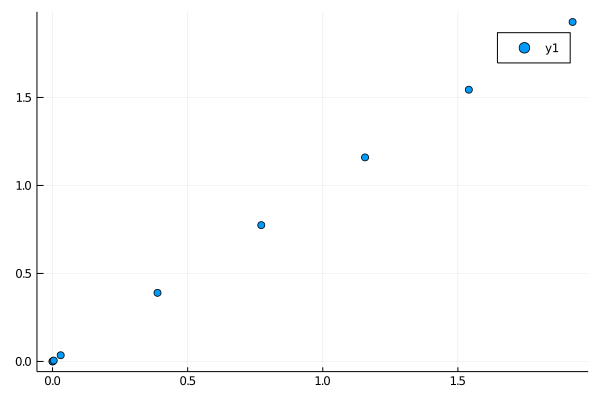

In [210]:
plot(xs, ys, seriestype = :scatter)
#plot!(rectangle(0.035,0.03,0.015,0), opacity=.5)

## Debug

In [190]:
(P*Q*ABw(k,i))[l,:]

2-element Array{Float64,1}:
 -0.1
  0.0

In [187]:
sum(P*Q*AB(k,i)*K[getK(j,i+1),:,:][l,:] for j=(i+1):(k-1))

2-element Array{GenericAffExpr{Float64,VariableRef},1}:
 -0.1 K[2,1,1]
 0.1 K[2,1,2]

In [ ]:
@constraint(model, [k=2:N,i=0:(k-2)], vcat(s[k-2+i+1,l], sum(
            B*K[getK(j,i+1),:,:] for j=(i+1):(k-1))) in SecondOrderCone());

In [ ]:
@constraint(model, [k=3:N-1], (P*Q*Ai(k)*x0+sum(P*Q*ABki(k,i)*α[:,i] for i=1:k-1)
        +sum(ρ*t[k-2+i+1,:] for i=0:k-2))

In [234]:
@constraint(model, [k=2:N,i=0:(k-2)], vcat(s[k-2+i+1,l], sum(
            B*K[getK(j,i+1),:,:] for j=(i+1):(k-1))) in SecondOrderCone());
@constraint(model, [k=2:N,i=0:(k-2),l=1:2], vcat(t[k-2+i+1,l], cki(k,i)[l,:]+sum(
            dki(k,j)*K[getK(j,i+1),:,:][l,:] for j=(i+1):(k-1))) in SecondOrderCone());
@constraint(model, [k=2:N-1], (η(k)*x0+sum(cki(k,i)*α[:,i+1] for i=0:k-1)
        +sum(ρ*t[k-2+i+1,:] for i=0:k-2)
        +ρ*mapslices(norm, A1*C*Bw, dims=2)[:]) .<= b1+M*z[k,:]);
@objective(model, Min, sum(au));

In [184]:
j = 1
(dki(k,j)*K[getK(j,i+1),:,:])[1,:]

2-element Array{GenericAffExpr{Float64,VariableRef},1}:
 -0.1 K[1,1,1]
 -0.1 K[1,1,2]

In [185]:
cki(k,i)[1,:]+(dki(k,j)*K[getK(j,i+1),:,:])[1,:]

2-element Array{GenericAffExpr{Float64,VariableRef},1}:
 -0.1 K[1,1,1] - 0.1
 -0.1 K[1,1,2]

In [173]:
K[getK(j,i+1),:,1]

2-element Array{VariableRef,1}:
 K[1,1,1]
 K[1,2,1]

In [175]:
sum(dki(k,j)[1,:]*K[getK(j,i+1),:,:] for j=(i+1):(k-1))

-0.1 K[1,1,1]

In [192]:
k,i = (2,0)
vcat(t[k,1], cki(k,i)[1,:]+sum(
        dki(k,j)*K[getK(j,i+1),:,:][1,:] for j=(i+1):(k-1)))

3-element Array{GenericAffExpr{Float64,VariableRef},1}:
 t[2,1]
 -0.1 K[1,1,1] - 0.1
 0.1 K[1,1,2]

In [223]:
@constraint(model, [k=2:N,i=0:(k-2),l=1:2], vcat(t[k-2+i+1,l], cki(k,i)[l,:]+sum(
            dki(k,j)*K[getK(j,i+1),:,:][l,:] for j=(i+1):(k-1))) in SecondOrderCone());

In [200]:
cki(k,i)

2×2 Array{Float64,2}:
 -0.1  0.0
  0.0  0.1

In [243]:
η(k)*x0

2-element Array{Float64,1}:
 0.0
 0.0

In [246]:
η(k)*x0+sum(cki(k,i)*α[:,i+1] for i=0:k-1)+sum(ρ*t[k-2+i+1,:] for i=0:k-2)

2-element Array{GenericAffExpr{Float64,VariableRef},1}:
 -0.1 α[1,1] - 0.1 α[1,2] + 3 t[1,1]
 0.1 α[2,1] + 0.1 α[2,2] + 3 t[1,2]

In [224]:
sum(ρ*t[k-2+i+1,:] for i=0:k-2)

2-element Array{GenericAffExpr{Float64,VariableRef},1}:
 3 t[1,1]
 3 t[1,2]

In [255]:
(η(k)*x0+sum(cki(k,i)*α[:,i+1] for i=0:k-1)
        +sum(ρ*t[k-2+i+1,:] for i=0:k-2)
        +ρ*mapslices(norm, A1*C*Bw, dims=2)[:])

2-element Array{GenericAffExpr{Float64,VariableRef},1}:
 -0.1 α[1,1] - 0.1 α[1,2] + 3 t[1,1] + 0.30000000000000004
 0.1 α[2,1] + 0.1 α[2,2] + 3 t[1,2] + 0.30000000000000004

In [239]:
b1+M*z[k,:]

2-element Array{GenericAffExpr{Float64,VariableRef},1}:
 1000 z[2,1] - 0.015
 1000 z[2,2] + 0.03

In [257]:
@constraint(model, [k=2:N-1], (η(k)*x0+sum(cki(k,i)*α[:,i+1] for i=0:k-1)
        +sum(ρ*t[k-2+i+1,:] for i=0:k-2)
        +ρ*mapslices(norm, A1*C*Bw, dims=2)[:]) .<= b1+M*z[k,:]);

1-dimensional DenseAxisArray{Array{ConstraintRef{Model,MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64},MathOptInterface.LessThan{Float64}},ScalarShape},1},1,...} with index sets:
    Dimension 1, 2:8
And data, a 7-element Array{Array{ConstraintRef{Model,MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64},MathOptInterface.LessThan{Float64}},ScalarShape},1},1}:
 [-0.1 α[1,1] - 0.1 α[1,2] + 3 t[1,1] - 1000 z[2,1] <= -0.31500000000000006, 0.1 α[2,1] + 0.1 α[2,2] + 3 t[1,2] - 1000 z[2,2] <= -0.27]
 [-0.1 α[1,1] - 0.1 α[1,2] - 0.1 α[1,3] + 3 t[2,1] + 3 t[3,1] - 1000 z[3,1] <= -0.31500000000000006, 0.1 α[2,1] + 0.1 α[2,2] + 0.1 α[2,3] + 3 t[2,2] + 3 t[3,2] - 1000 z[3,2] <= -0.27]
 [-0.1 α[1,1] - 0.1 α[1,2] - 0.1 α[1,3] - 0.1 α[1,4] + 3 t[3,1] + 3 t[4,1] + 3 t[5,1] - 1000 z[4,1] <= -0.31500000000000006, 0.1 α[2,1] + 0.1 α[2,2] + 0.1 α[2,3] + 0.1 α[2,4] + 3 t[3,2] + 3 t[4,2] + 3 t[5,2] - 1000 z[4,2] <= -0.27]
 [-0.1 α[1,1] - 0.1 α[1,2]

### Dual formulation

In [4]:
model = Model(optimizer_with_attributes(
        () -> Gurobi.Optimizer(GRB_ENV), #"OutputFlag" => 0
    ));
@variable(model, r1[1:2]>=0)
@variable(model, r2[1:2]>=0)
@variable(model, q[1:2, 1:N]>=0)
@variable(model, p[1:2, 1:N]>=0)
@variable(model, u[1:2, 1:N-1])
@variable(model, au[1:2, 1:N-1] >=0)
@variable(model, z[1:2, 1:N-1] >=0, Bin)
@constraint(model, (dot(γ_1,r1)+dot(γ_2,r2)+dot(β,sum(q+p,dims=2)+
        sum(-M*z+dki*u)))
#@variable(model, g[1:N], Bin)
#@variable(model, ag[1:4, 1:N] >= 0)
@constraint(model, [k=1:N], A1*x[[1,3],k] -b1 + M*z[k,:] .>= 0 )
@constraint(model, sum(z, dims=2) .== N1-1)
@constraint(model, x[:,1] .== x0)
@constraint(model, x[:,N] .== xN)
@constraint(model, [k=1:N-1], x[:,k+1] .== A*x[:,k]+B*u[:,k])
#@constraint(model, [k=1:N-1], y[:,k+1] .== C*x[:,k]) #sensor output
@constraint(model, -au .<= u)
@constraint(model, u .<= au)
@constraint(model, au .<= 0.5)
#@constraint(model, [k=1:N], -ag[:,k] .<= x[:, k] - xN)
#@constraint(model, [k=1:N], x[:, k] - xN .<= ag[:,k])
#@constraint(model, [k=1:N,i=1:4], -1000*g[k]+ag[i,k] .<= epsilon)
#@constraint(model, -1 .<= x[[2,4],:] .<= 1) # velocity constraint
#@objective(model, Min, sum(g));
@objective(model, Min, sum(au));